Imports of all the libraries used and stuff:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D,Dropout,Dense,Flatten, Activation, Convolution2D, MaxPooling2D, BatchNormalization, Conv2D,MaxPool2D, ZeroPadding2D
from keras.models import Sequential, Model

from google.colab import files

In [ ]:
# using data from https://www.kaggle.com/c/facial-keypoints-detection/data
data_files = files.upload()

Saving IdLookupTable.csv to IdLookupTable.csv
Saving test.csv to test.csv
Saving training.csv to training.csv


Reading the data:

In [ ]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
lookup = pd.read_csv('IdLookupTable.csv')

Some checks to see the data and ensure I did not mysteriously load p... some wrong data:

In [ ]:
train.head().T

In [ ]:
test.head().T

,0,1,2,3,4
ImageId,1,2,3,4,5
Image,182 183 182 182 180 180 176 169 156 137 124 10...,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,177 176 174 170 169 169 168 166 166 166 161 14...,176 174 174 175 174 174 176 176 175 171 165 15...,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


Checking for nulls and removing them if found.

In [ ]:
train.isnull().any().value_counts()

True     28
False     3
dtype: int64

In [ ]:
train.fillna(method = 'ffill',inplace = True)
train.isnull().any().value_counts()

False    31
dtype: int64

Processing images and keypoints.

In [ ]:
def get_images(data):
    images = []
    for idx, sample in data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

In [ ]:
def get_keypoints(data):
    keypoint = data.drop('Image',axis = 1)
    keypoints = []
    for idx, sample_keypoints in keypoint.iterrows():
        keypoints.append(sample_keypoints)
    keypoints = np.array(keypoints, dtype = 'float')
    return keypoints

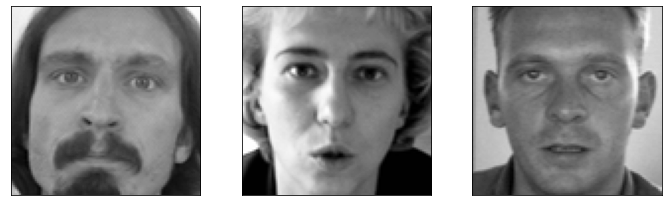

In [ ]:
X_train = get_images(train)
y_train = get_keypoints(train)

fig = plt.figure(figsize=(20,16))
for i in range(3):
  img = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
  img.imshow(X_train[i].reshape(96,96),cmap='gray')
fig.show()

**Building the model**

In [ ]:
def build_model(layers_num):
  model = Sequential()

  model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  for i in range(layers_num):
    model.add(Convolution2D(32 * 2 ** i, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(30))

  model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])

  return model


In [ ]:
model = build_model(3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        1

In [ ]:
history = model.fit(X_train,y_train,epochs = 10,batch_size = 64,validation_split = 0.2)

Epoch 1/10
89/89 [==============================] - 88s 994ms/step - loss: 151.3514 - acc: 0.3394 - val_loss: 912.2819 - val_acc: 0.6858
Epoch 2/10
89/89 [==============================] - 89s 1s/step - loss: 34.4555 - acc: 0.4417 - val_loss: 404.1617 - val_acc: 0.5752
Epoch 3/10
89/89 [==============================] - 90s 1s/step - loss: 28.9270 - acc: 0.4783 - val_loss: 141.1147 - val_acc: 0.4525
Epoch 4/10
89/89 [==============================] - 88s 992ms/step - loss: 24.8623 - acc: 0.5233 - val_loss: 79.8029 - val_acc: 0.3837
Epoch 5/10
89/89 [==============================] - 89s 1s/step - loss: 24.0939 - acc: 0.5387 - val_loss: 97.7901 - val_acc: 0.5582
Epoch 6/10
89/89 [==============================] - 89s 997ms/step - loss: 20.8654 - acc: 0.5641 - val_loss: 64.5264 - val_acc: 0.6652
Epoch 7/10
89/89 [==============================] - 89s 995ms/step - loss: 20.2069 - acc: 0.5771 - val_loss: 49.0406 - val_acc: 0.7064
Epoch 8/10
89/89 [==============================] - 89s 1s/s

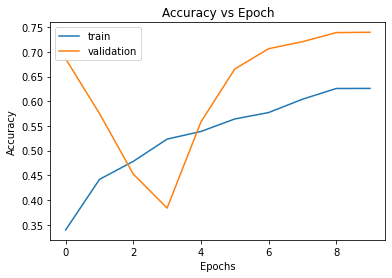

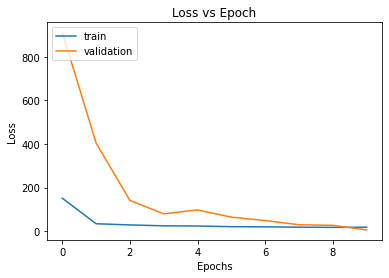

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Testing**

In [ ]:
X_test = get_images(test)
preds = model.predict(X_test)

In [ ]:
def plot_prediction_results(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', color='red', s=20)
    plt.title(title)

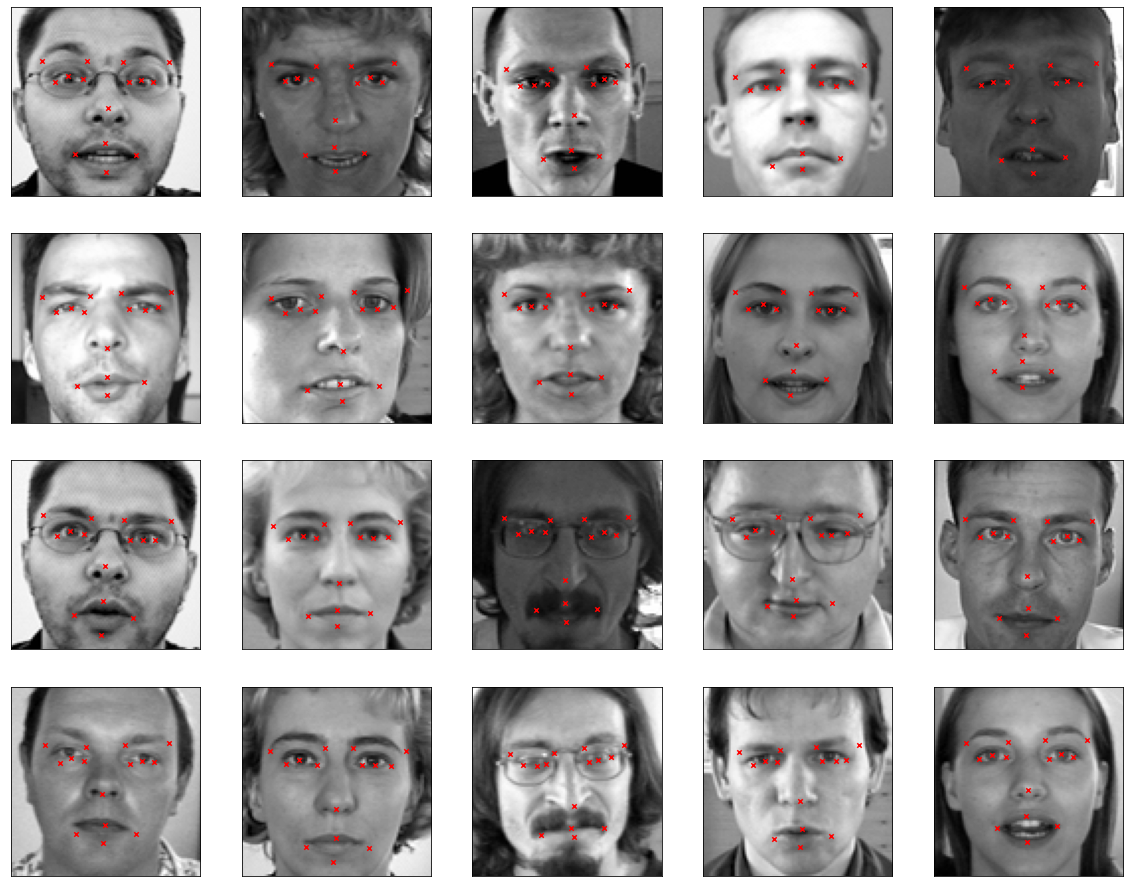

In [ ]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_prediction_results(X_test[i], preds[i], axis, "")
plt.show()

In [ ]:
feature = list(lookup['FeatureName'])
image_ids = list(lookup['ImageId']-1)
row_ids = lookup['RowId']
prediction_list = list(preds)

feature_list = []
for f in feature:
    feature_list.append(feature.index(f))

final_predictions = []
for x,y in zip(image_ids, feature_list):
    final_predictions.append(prediction_list[x][y])

row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(final_predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
result = pd.concat([row_ids,locations],axis = 1)
result.to_csv('predictions.csv',index = False)
result


,RowId,Location
0,1,65.684021
1,2,36.546589
2,3,28.827082
3,4,34.960754
4,5,59.739796
...,...,...
27119,27120,38.049641
27120,27121,47.582317
27121,27122,61.506668
27122,27123,46.896595
